## Application to a realistic case study
for Ensemble Refinement and Force-Field Fitting

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../')

In [3]:
from MDRefine.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict, loss_function
from Functions.basic_functions_bayesian import local_density, run_Metropolis

look at the Kish size (or the relative entropy) during the MC sampling

### 1. load data

In [4]:
infos = {'global': {
    # 'path_directory': '../../3_alphabetagamma/MDRefine/tests/DATA_test',
    # DATA_test corresponds to stride = 1e4 and only one observable per type
    
    'path_directory': '../DATA/',
    
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J'],  # , 'backbone2_beta_epsilon_3J', 'sugar_3J'],#, 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma'],  # , 'backbone2_beta_epsilon', 'sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 100

In [5]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2]}
        # 'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        # 'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [6]:
infos['global']['forward_model'] = forward_model_fun

In [7]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [8]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


### 2. normalize observables and find the optimal solution at given $\alpha$

In [9]:
name_mol = 'AAAA'

normalization: just once, at the beginning of Metropolis sampling

in order to simplify a (global) pre-factor in the Jeffreys prior

In [10]:
out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

data.mol[name_mol].g = out[0]
data.mol[name_mol].gexp = out[1]
data.mol[name_mol].normg_mean = out[2]
data.mol[name_mol].normg_std = out[3]

In [11]:
result = minimizer(data, alpha=1)  # this will be used in the next section, n.3

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [12]:
print(vars(result).keys())

result.min_lambdas

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])


{'AAAA': {'backbone1_gamma_3J': Array([-0.34310767, -0.03502595,  0.07585679,  0.49756582, -0.01568491,
          0.0062284 ,  0.2019403 ,  0.02059424], dtype=float64)}}

#### compute determinant of the covariance matrix

In [30]:
measures = {}
covs = {}

In [31]:
measures['obs 0'], covs['obs 0'] = local_density(data.mol[name_mol].g, data.mol[name_mol].weights)


[[ 1.00000000e+00 -3.11004441e-01  1.37022254e-02 -2.41415658e-02
  -2.32903220e-02  6.49500694e-03  4.65506871e-03 -1.00029632e-02
  -5.15333768e-02 -4.55140739e-02 -3.41167355e-02  1.11629003e-01
   1.65194277e-02 -2.47360286e-02 -5.87412540e-03 -3.86711956e-02
   2.27532023e-02 -1.38405840e-01 -5.83087891e-02  1.41483755e-01
  -2.24188130e-02 -1.61659684e-02  1.83154493e-02 -3.19256432e-02
   2.19808171e-03  3.77320331e-02  9.44629507e-03 -2.14892410e-02]
 [-3.11004441e-01  1.00000000e+00 -4.60509672e-03 -1.56466733e-02
   1.88672900e-02 -3.83142778e-03  1.88903685e-02 -3.27633588e-02
   5.01826358e-02  2.91556298e-02 -1.39670260e-02  3.70778832e-02
  -2.10999652e-02  1.17618944e-02  8.77783663e-03 -6.40587212e-03
   3.03021058e-03 -1.77887232e-02 -6.48393374e-03 -1.53775450e-02
  -1.46773139e-02 -5.59087914e-03  1.48247164e-02 -1.61642641e-02
  -2.61712725e-02  6.32315261e-03  4.82021926e-02 -4.90968679e-02]
 [ 1.37022254e-02 -4.60509672e-03  1.00000000e+00 -3.88135492e-01
  -3.846

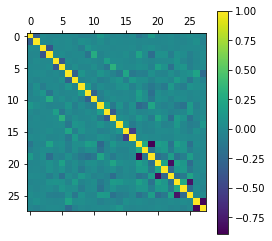

In [32]:
print(covs['obs 0'])
print(measures['obs 0'])

plt.matshow(covs['obs 0'])
plt.colorbar()

In [33]:
ff_correction = data.mol[name_mol].ff_correction

f = data.mol[name_mol].f
fun_forces = jax.jacfwd(ff_correction, argnums=0)
pars = np.ones(2)

measures['ff 0'], covs['ff 0'] = local_density((fun_forces, pars, f), data.mol[name_mol].weights)

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (1,).

[[ 2.37446073 -0.21772175]
 [-0.21772175  0.41964628]]
0.9741821468305136


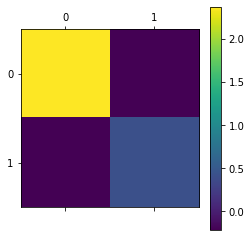

In [16]:
print(covs['ff 0'])
print(measures['ff 0'])

plt.matshow(covs['ff 0'])
plt.colorbar()

In [17]:
vars(result)

result.min_lambdas['AAAA']['backbone1_gamma_3J']

DeviceArray([-0.36735067, -0.06547362], dtype=float64)

In [18]:
weights_new = result.weights_new[name_mol]

In [19]:
measures['obs opt'], covs['obs opt'] = local_density(data.mol[name_mol].g, weights_new)

In [20]:
# notice this is the force-field correction with the reweighted ensemble from Ensemble Refinement
# pars are arbitrarily chosen (they should be zero)
measures['ff opt'], covs['ff opt'] = local_density((fun_forces, pars, f), weights_new)

0.7936978338214815 0.7761417788123444


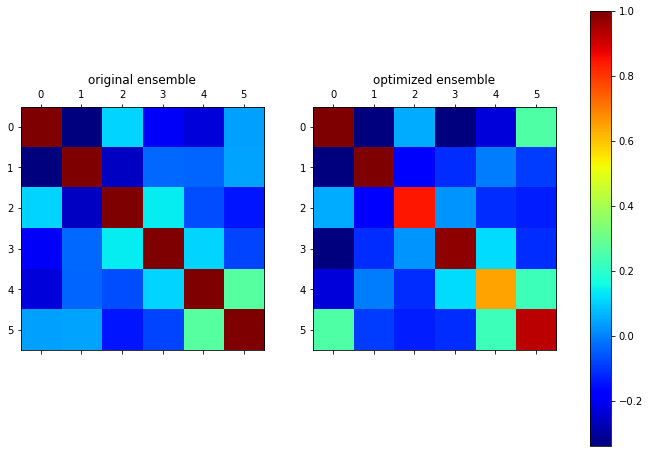

In [21]:
# print(covs['obs opt'])
print(measures['obs 0'], measures['obs opt'])

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].matshow(covs['obs 0'], cmap='jet')
axs[0].set_title('original ensemble')

minim = np.min(covs['obs 0'])
maxim = np.max(covs['obs 0'])

im = axs[1].matshow(covs['obs opt'], cmap='jet', vmin=minim, vmax=maxim)
axs[1].set_title('optimized ensemble')

plt.colorbar(im, ax=axs.ravel().tolist())

### 3. sample the posterior at this given value of the hyperparameters
(Ensemble Refinement: sampling ${P_\lambda}$ ensemble; only $\alpha$ is finite, $\alpha=1$)

In [68]:
from MDRefine.MDRefine import loss_function

In [69]:
lambdas = result.min_lambdas
result.loss

Array(0.27761306, dtype=float64)

In [70]:
flatten_lambda = []
for name_mol in data.properties.system_names:
    flatten_lambda = flatten_lambda + list(
        np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

flatten_lambda = np.array(flatten_lambda)

#### compute and plot

In [71]:
loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda)

Array(0.27761306, dtype=float64)

In [72]:
out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda, if_save=True)

vars(out)

out.weights_new['AAAA']

Array([9.70172574e-05, 6.10515195e-05, 1.01610865e-04, ...,
       7.53823195e-05, 9.68416324e-05, 8.16376593e-05], dtype=float64)

In [73]:
result.weights_new['AAAA']

Array([9.70172574e-05, 6.10515195e-05, 1.01610865e-04, ...,
       7.53823195e-05, 9.68416324e-05, 8.16376593e-05], dtype=float64)

ok, it's correct

In [40]:
new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)

In [41]:
out.loss

Array(4.78156356, dtype=float64)

In [42]:
out.loss_explicit

Array(4.79890871, dtype=float64)

In [93]:
measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])

np.log(measure)

0.6348770076238053

In [44]:
out.av_g['AAAA']

{'backbone1_gamma_3J': Array([ 0.49221345, -0.00991152,  0.0451607 , -0.19428969,  0.05365722,
        -0.01918176, -0.1432338 ,  0.03606927], dtype=float64),
 'backbone2_beta_epsilon_3J': Array([ 0.58130118,  0.10106933, -0.30982421,  0.56413102, -0.07348793,
        -0.13580689,  0.80874268,  0.22208402, -0.43305767], dtype=float64),
 'sugar_3J': Array([-0.13964639, -0.40132476, -0.30712706, -0.02517725, -0.17343226,
        -0.20128059, -0.04906851, -0.24462923, -0.22650346, -0.35123614,
         0.14555381], dtype=float64)}

In [94]:
values = []
avgs = []

for i in range(500):
    
    new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)
    measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])

    values.append([out.loss_explicit, np.log(measure)])
    avgs.append(out.av_g['AAAA']['backbone1_gamma_3J'])

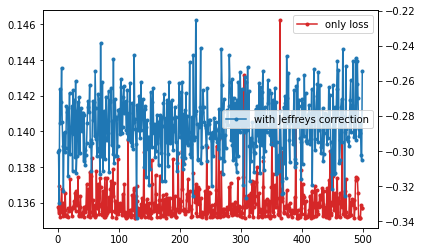

In [95]:
values = np.array(values)

fig, ax1 = plt.subplots()

ax1.plot(values[:, 0], '.-', color='tab:red', label='only loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(values[:, 0] - values[:, 1], '.-', color='tab:blue', label='with Jeffreys correction')

ax2.legend(loc='right')


In [96]:
avgs = np.array(avgs)

0.5353565064294799 0.5351511461152612
-0.07847067114934533 -0.07857868514636715


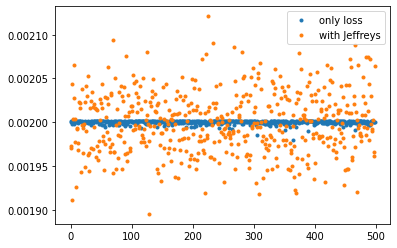

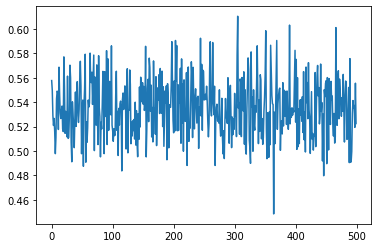

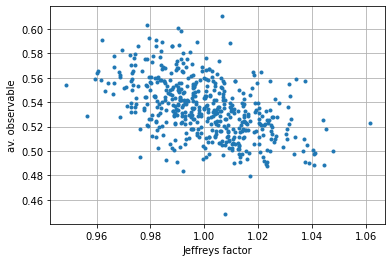

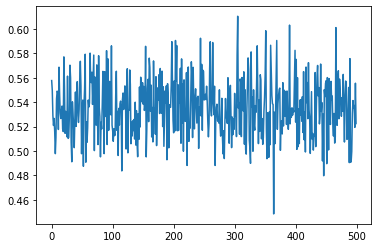

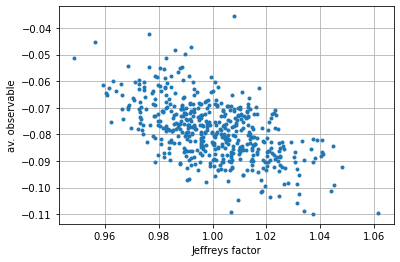

In [97]:
bayes_weight = np.exp(-values[:, 0])
bayes_weight = bayes_weight/np.sum(bayes_weight)

bayes_weight2 = np.exp(-values[:, 1])
bayes_weight2 = bayes_weight2/np.sum(bayes_weight2)

plt.plot(bayes_weight, '.', label='only loss')
plt.plot(bayes_weight2, '.', label='with Jeffreys')
plt.legend()

for i_obs in range(avgs.shape[1]):

    bayes_av = np.sum(bayes_weight*avgs[:, i_obs])
    bayes_av2 = np.sum(bayes_weight2*avgs[:, i_obs])

    plt.figure()
    plt.plot(avgs[:, 0])

    print(bayes_av, bayes_av2)

    plt.figure()
    plt.plot(bayes_weight2/bayes_weight, avgs[:, i_obs], '.')
    plt.xlabel('Jeffreys factor')
    plt.ylabel('av. observable')
    plt.grid()

#### Metropolis sampling

In [26]:
x0 = flatten_lambda

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_move = lambda x0 : proposal(x0, 0.01)

def energy_fun(lambdas, if_Jeffreys):
    
    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=lambdas, if_save=True)
    
    """ vars(out).keys() = ['loss', 'loss_explicit', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2',
            'logZ_new', 'weights_new'] """
    
    energy = out.loss_explicit

    # quantities = 

    av_g = unwrap_2dict(out.av_g)[0]

    if if_Jeffreys:
        name_mol = list(out.weights_new.keys())[0]
        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        energy -= np.log(measure)
    
    return energy, av_g

NameError: name 'flatten_lambda' is not defined

In [75]:
energy_function = lambda x0 : energy_fun(x0, True)
# energy_function = {'fun': energy_fun, 'args': ([True])}

sampling_J = run_Metropolis(x0, proposal_move, energy_function, n_steps=5000)

  0%|          | 5/5000 [00:00<01:40, 49.46it/s]

0


  0%|          | 21/5000 [00:00<01:13, 67.67it/s]

  1%|          | 36/5000 [00:00<01:10, 70.36it/s]

  1%|          | 53/5000 [00:00<01:05, 75.52it/s]

  1%|▏         | 69/5000 [00:00<01:05, 75.31it/s]

  2%|▏         | 85/5000 [00:01<01:05, 75.49it/s]

  2%|▏         | 101/5000 [00:01<01:04, 75.71it/s]

100


  2%|▏         | 117/5000 [00:01<01:05, 74.79it/s]

  3%|▎         | 133/5000 [00:01<01:09, 70.31it/s]

  3%|▎         | 141/5000 [00:01<01:10, 68.70it/s]

  3%|▎         | 148/5000 [00:02<01:10, 68.40it/s]

  3%|▎         | 155/5000 [00:02<01:11, 68.20it/s]

  3%|▎         | 162/5000 [00:02<01:11, 67.69it/s]

  3%|▎         | 169/5000 [00:02<01:12, 66.59it/s]

  4%|▎         | 176/5000 [00:02<01:12, 66.40it/s]

  4%|▎         | 184/5000 [00:02<01:10, 68.27it/s]

  4%|▍         | 192/5000 [00:02<01:07, 71.20it/s]

  4%|▍         | 200/5000 [00:02<01:05, 72.85it/s]

200


  4%|▍         | 216/5000 [00:03<01:05, 73.28it/s]

  5%|▍         | 232/5000 [00:03<01:04, 74.03it/s]

  5%|▍         | 249/5000 [00:03<01:02, 75.90it/s]

  5%|▌         | 265/5000 [00:03<01:02, 75.35it/s]

  6%|▌         | 281/5000 [00:03<01:01, 77.19it/s]

  6%|▌         | 298/5000 [00:04<01:00, 78.31it/s]

300


  6%|▋         | 315/5000 [00:04<00:59, 78.60it/s]

  7%|▋         | 332/5000 [00:04<00:58, 80.08it/s]

  7%|▋         | 350/5000 [00:04<00:58, 80.05it/s]

  7%|▋         | 368/5000 [00:04<00:56, 81.51it/s]

  8%|▊         | 386/5000 [00:05<00:55, 82.83it/s]

  8%|▊         | 404/5000 [00:05<00:55, 83.28it/s]

400


  8%|▊         | 422/5000 [00:05<00:54, 83.39it/s]

  9%|▉         | 440/5000 [00:05<00:53, 84.45it/s]

  9%|▉         | 458/5000 [00:06<00:53, 84.87it/s]

 10%|▉         | 476/5000 [00:06<00:53, 84.95it/s]

 10%|▉         | 494/5000 [00:06<00:52, 85.02it/s]

 10%|█         | 512/5000 [00:06<00:52, 84.68it/s]

500


 10%|█         | 521/5000 [00:06<00:53, 83.74it/s]

 11%|█         | 539/5000 [00:06<00:53, 83.87it/s]

 11%|█         | 557/5000 [00:07<00:58, 75.33it/s]

 11%|█▏        | 574/5000 [00:07<00:57, 76.95it/s]

 12%|█▏        | 591/5000 [00:07<00:55, 79.69it/s]

 12%|█▏        | 609/5000 [00:07<00:53, 82.20it/s]

600


 13%|█▎        | 627/5000 [00:08<00:52, 83.22it/s]

 13%|█▎        | 645/5000 [00:08<00:52, 83.12it/s]

 13%|█▎        | 654/5000 [00:08<00:53, 81.43it/s]

 14%|█▎        | 681/5000 [00:08<00:50, 85.00it/s]

 14%|█▍        | 690/5000 [00:08<00:51, 84.29it/s]

 14%|█▍        | 708/5000 [00:09<00:50, 85.17it/s]

700


 15%|█▍        | 726/5000 [00:09<00:49, 85.81it/s]

 15%|█▍        | 745/5000 [00:09<00:48, 86.85it/s]

 15%|█▌        | 763/5000 [00:09<00:48, 86.74it/s]

 16%|█▌        | 781/5000 [00:09<00:49, 85.66it/s]

 16%|█▌        | 799/5000 [00:10<00:49, 85.42it/s]

800


 16%|█▋        | 817/5000 [00:10<00:48, 86.27it/s]

 17%|█▋        | 835/5000 [00:10<00:48, 85.92it/s]

 17%|█▋        | 853/5000 [00:10<00:48, 84.87it/s]

 17%|█▋        | 871/5000 [00:10<00:49, 82.60it/s]

 18%|█▊        | 889/5000 [00:11<00:48, 83.96it/s]

 18%|█▊        | 907/5000 [00:11<00:47, 85.38it/s]

900


 18%|█▊        | 925/5000 [00:11<00:48, 84.87it/s]

 19%|█▉        | 943/5000 [00:11<00:46, 86.76it/s]

 19%|█▉        | 961/5000 [00:12<00:46, 87.36it/s]

 20%|█▉        | 981/5000 [00:12<00:44, 89.68it/s]

 20%|██        | 1000/5000 [00:12<00:44, 89.56it/s]

1000


 20%|██        | 1018/5000 [00:12<00:45, 87.72it/s]

 21%|██        | 1036/5000 [00:12<00:46, 85.07it/s]

 21%|██        | 1055/5000 [00:13<00:45, 86.21it/s]

 21%|██▏       | 1074/5000 [00:13<00:44, 88.21it/s]

 22%|██▏       | 1093/5000 [00:13<00:43, 88.99it/s]

 22%|██▏       | 1112/5000 [00:13<00:43, 89.84it/s]

1100


 23%|██▎       | 1132/5000 [00:13<00:42, 91.30it/s]

 23%|██▎       | 1142/5000 [00:14<00:42, 91.46it/s]

 23%|██▎       | 1162/5000 [00:14<00:43, 88.97it/s]

 24%|██▎       | 1180/5000 [00:14<00:43, 88.68it/s]

 24%|██▍       | 1198/5000 [00:14<00:43, 87.32it/s]

1200


 24%|██▍       | 1218/5000 [00:14<00:42, 89.37it/s]

 25%|██▍       | 1237/5000 [00:15<00:41, 90.82it/s]

 25%|██▌       | 1257/5000 [00:15<00:41, 90.51it/s]

 26%|██▌       | 1276/5000 [00:15<00:42, 87.40it/s]

 26%|██▌       | 1294/5000 [00:15<00:42, 87.51it/s]

 26%|██▌       | 1312/5000 [00:15<00:42, 86.99it/s]

1300


 27%|██▋       | 1331/5000 [00:16<00:41, 88.71it/s]

 27%|██▋       | 1349/5000 [00:16<00:41, 87.31it/s]

 27%|██▋       | 1367/5000 [00:16<00:42, 86.46it/s]

 28%|██▊       | 1385/5000 [00:16<00:41, 86.32it/s]

 28%|██▊       | 1403/5000 [00:17<00:41, 86.31it/s]

1400


 28%|██▊       | 1421/5000 [00:17<00:40, 87.32it/s]

 29%|██▉       | 1439/5000 [00:17<00:41, 86.80it/s]

 29%|██▉       | 1457/5000 [00:17<00:42, 83.42it/s]

 30%|██▉       | 1475/5000 [00:17<00:42, 83.60it/s]

 30%|██▉       | 1484/5000 [00:17<00:41, 84.43it/s]

 30%|███       | 1503/5000 [00:18<00:40, 85.82it/s]

1500


 30%|███       | 1521/5000 [00:18<00:41, 84.45it/s]

 31%|███       | 1539/5000 [00:18<00:41, 82.76it/s]

 31%|███       | 1557/5000 [00:18<00:41, 83.12it/s]

 32%|███▏      | 1575/5000 [00:19<00:40, 85.49it/s]

 32%|███▏      | 1593/5000 [00:19<00:39, 87.19it/s]

 32%|███▏      | 1611/5000 [00:19<00:38, 87.95it/s]

1600


 33%|███▎      | 1629/5000 [00:19<00:38, 87.96it/s]

 33%|███▎      | 1647/5000 [00:19<00:39, 84.25it/s]

 33%|███▎      | 1665/5000 [00:20<00:39, 85.12it/s]

 34%|███▎      | 1683/5000 [00:20<00:38, 85.73it/s]

 34%|███▍      | 1701/5000 [00:20<00:39, 83.10it/s]

1700


 34%|███▍      | 1719/5000 [00:20<00:39, 82.58it/s]

 35%|███▍      | 1737/5000 [00:20<00:39, 83.18it/s]

 35%|███▌      | 1755/5000 [00:21<00:38, 83.53it/s]

 35%|███▌      | 1764/5000 [00:21<00:39, 82.31it/s]

 36%|███▌      | 1782/5000 [00:21<00:39, 82.12it/s]

 36%|███▌      | 1800/5000 [00:21<00:38, 82.31it/s]

1800


 36%|███▋      | 1818/5000 [00:21<00:39, 80.55it/s]

 37%|███▋      | 1836/5000 [00:22<00:38, 82.26it/s]

 37%|███▋      | 1854/5000 [00:22<00:37, 83.52it/s]

 37%|███▋      | 1872/5000 [00:22<00:37, 82.41it/s]

 38%|███▊      | 1890/5000 [00:22<00:38, 81.81it/s]

 38%|███▊      | 1908/5000 [00:23<00:37, 83.35it/s]

1900


 39%|███▊      | 1926/5000 [00:23<00:36, 84.81it/s]

 39%|███▉      | 1944/5000 [00:23<00:36, 83.49it/s]

 39%|███▉      | 1962/5000 [00:23<00:35, 85.07it/s]

 40%|███▉      | 1980/5000 [00:23<00:35, 85.13it/s]

 40%|███▉      | 1998/5000 [00:24<00:36, 83.08it/s]

 40%|████      | 2007/5000 [00:24<00:41, 72.08it/s]

2000


 40%|████      | 2024/5000 [00:24<00:39, 75.95it/s]

 41%|████      | 2042/5000 [00:24<00:36, 80.61it/s]

 41%|████      | 2060/5000 [00:24<00:36, 80.65it/s]

 42%|████▏     | 2078/5000 [00:25<00:35, 82.00it/s]

 42%|████▏     | 2096/5000 [00:25<00:35, 81.30it/s]

 42%|████▏     | 2115/5000 [00:25<00:33, 86.26it/s]

2100


 43%|████▎     | 2133/5000 [00:25<00:33, 85.46it/s]

 43%|████▎     | 2142/5000 [00:25<00:34, 83.53it/s]

 43%|████▎     | 2160/5000 [00:26<00:34, 81.79it/s]

 44%|████▎     | 2178/5000 [00:26<00:34, 81.45it/s]

 44%|████▍     | 2196/5000 [00:26<00:34, 81.46it/s]

2200


 44%|████▍     | 2214/5000 [00:26<00:34, 81.08it/s]

 45%|████▍     | 2232/5000 [00:27<00:33, 81.80it/s]

 45%|████▌     | 2250/5000 [00:27<00:33, 82.54it/s]

 45%|████▌     | 2268/5000 [00:27<00:32, 83.31it/s]

 46%|████▌     | 2286/5000 [00:27<00:32, 83.01it/s]

 46%|████▌     | 2304/5000 [00:27<00:32, 82.85it/s]

2300


 46%|████▋     | 2313/5000 [00:28<00:32, 82.49it/s]

 47%|████▋     | 2331/5000 [00:28<00:32, 83.14it/s]

 47%|████▋     | 2349/5000 [00:28<00:31, 83.99it/s]

 47%|████▋     | 2367/5000 [00:28<00:31, 84.45it/s]

 48%|████▊     | 2385/5000 [00:28<00:30, 85.77it/s]

 48%|████▊     | 2403/5000 [00:29<00:30, 85.18it/s]

2400


 48%|████▊     | 2421/5000 [00:29<00:33, 77.74it/s]

 49%|████▉     | 2438/5000 [00:29<00:33, 76.64it/s]

 49%|████▉     | 2456/5000 [00:29<00:31, 80.90it/s]

 49%|████▉     | 2474/5000 [00:29<00:30, 81.52it/s]

 50%|████▉     | 2492/5000 [00:30<00:29, 83.86it/s]

 50%|█████     | 2510/5000 [00:30<00:29, 84.40it/s]

2500


 51%|█████     | 2528/5000 [00:30<00:29, 84.66it/s]

 51%|█████     | 2546/5000 [00:30<00:29, 84.16it/s]

 51%|█████▏    | 2564/5000 [00:31<00:28, 84.12it/s]

 51%|█████▏    | 2573/5000 [00:31<00:29, 82.92it/s]

 52%|█████▏    | 2591/5000 [00:31<00:28, 83.27it/s]

 52%|█████▏    | 2609/5000 [00:31<00:28, 83.69it/s]

2600


 53%|█████▎    | 2627/5000 [00:31<00:28, 84.18it/s]

 53%|█████▎    | 2645/5000 [00:31<00:27, 84.93it/s]

 53%|█████▎    | 2663/5000 [00:32<00:27, 85.56it/s]

 54%|█████▎    | 2681/5000 [00:32<00:27, 85.35it/s]

 54%|█████▍    | 2699/5000 [00:32<00:26, 85.37it/s]

2700


 54%|█████▍    | 2717/5000 [00:32<00:27, 83.91it/s]

 55%|█████▍    | 2735/5000 [00:33<00:26, 84.63it/s]

 55%|█████▌    | 2753/5000 [00:33<00:26, 85.50it/s]

 55%|█████▌    | 2771/5000 [00:33<00:27, 82.25it/s]

 56%|█████▌    | 2780/5000 [00:33<00:28, 76.81it/s]

 56%|█████▌    | 2797/5000 [00:33<00:28, 76.42it/s]

2800


 56%|█████▋    | 2815/5000 [00:34<00:27, 79.40it/s]

 57%|█████▋    | 2832/5000 [00:34<00:26, 81.02it/s]

 57%|█████▋    | 2850/5000 [00:34<00:25, 83.03it/s]

 57%|█████▋    | 2868/5000 [00:34<00:25, 83.48it/s]

 58%|█████▊    | 2886/5000 [00:34<00:25, 84.35it/s]

 58%|█████▊    | 2904/5000 [00:35<00:24, 84.74it/s]

2900


 58%|█████▊    | 2922/5000 [00:35<00:24, 85.07it/s]

 59%|█████▉    | 2940/5000 [00:35<00:24, 85.55it/s]

 59%|█████▉    | 2958/5000 [00:35<00:24, 84.62it/s]

 60%|█████▉    | 2976/5000 [00:35<00:23, 85.12it/s]

 60%|█████▉    | 2994/5000 [00:36<00:23, 86.07it/s]

 60%|██████    | 3012/5000 [00:36<00:23, 85.03it/s]

3000


 61%|██████    | 3030/5000 [00:36<00:23, 84.88it/s]

 61%|██████    | 3048/5000 [00:36<00:22, 85.97it/s]

 61%|██████▏   | 3066/5000 [00:37<00:22, 86.44it/s]

 62%|██████▏   | 3084/5000 [00:37<00:23, 82.77it/s]

 62%|██████▏   | 3093/5000 [00:37<00:23, 80.99it/s]

 62%|██████▏   | 3111/5000 [00:37<00:23, 81.25it/s]

3100


 63%|██████▎   | 3129/5000 [00:37<00:22, 82.12it/s]

 63%|██████▎   | 3147/5000 [00:38<00:22, 83.41it/s]

 63%|██████▎   | 3165/5000 [00:38<00:22, 83.22it/s]

 64%|██████▎   | 3183/5000 [00:38<00:21, 83.39it/s]

 64%|██████▍   | 3201/5000 [00:38<00:21, 82.47it/s]

3200


 64%|██████▍   | 3219/5000 [00:38<00:21, 82.20it/s]

 65%|██████▍   | 3228/5000 [00:39<00:21, 82.08it/s]

 65%|██████▍   | 3246/5000 [00:39<00:21, 83.12it/s]

 65%|██████▌   | 3264/5000 [00:39<00:20, 84.18it/s]

 66%|██████▌   | 3282/5000 [00:39<00:20, 83.95it/s]

 66%|██████▌   | 3300/5000 [00:39<00:20, 83.18it/s]

3300


 66%|██████▋   | 3318/5000 [00:40<00:20, 83.85it/s]

 67%|██████▋   | 3336/5000 [00:40<00:19, 83.22it/s]

 67%|██████▋   | 3354/5000 [00:40<00:19, 83.58it/s]

 67%|██████▋   | 3372/5000 [00:40<00:19, 84.65it/s]

 68%|██████▊   | 3381/5000 [00:40<00:19, 84.21it/s]

 68%|██████▊   | 3398/5000 [00:41<00:21, 73.42it/s]

3400


 68%|██████▊   | 3415/5000 [00:41<00:20, 76.27it/s]

 69%|██████▊   | 3432/5000 [00:41<00:20, 78.11it/s]

 69%|██████▉   | 3450/5000 [00:41<00:19, 79.05it/s]

 69%|██████▉   | 3467/5000 [00:41<00:18, 81.35it/s]

 70%|██████▉   | 3485/5000 [00:42<00:19, 76.91it/s]

 70%|███████   | 3503/5000 [00:42<00:18, 80.87it/s]

3500


 70%|███████   | 3521/5000 [00:42<00:17, 83.19it/s]

 71%|███████   | 3539/5000 [00:42<00:17, 85.17it/s]

 71%|███████   | 3557/5000 [00:43<00:17, 84.07it/s]

 71%|███████▏  | 3566/5000 [00:43<00:20, 71.31it/s]

 72%|███████▏  | 3583/5000 [00:43<00:18, 75.11it/s]

 72%|███████▏  | 3601/5000 [00:43<00:17, 79.40it/s]

3600


 72%|███████▏  | 3619/5000 [00:43<00:17, 81.02it/s]

 73%|███████▎  | 3628/5000 [00:43<00:16, 81.08it/s]

 73%|███████▎  | 3646/5000 [00:44<00:16, 81.16it/s]

 73%|███████▎  | 3664/5000 [00:44<00:16, 82.67it/s]

 74%|███████▎  | 3682/5000 [00:44<00:15, 83.31it/s]

 74%|███████▍  | 3700/5000 [00:44<00:15, 84.69it/s]

3700


 74%|███████▍  | 3718/5000 [00:45<00:15, 84.33it/s]

 75%|███████▍  | 3736/5000 [00:45<00:15, 84.20it/s]

 75%|███████▍  | 3745/5000 [00:45<00:14, 84.09it/s]

 75%|███████▌  | 3763/5000 [00:45<00:17, 71.68it/s]

 76%|███████▌  | 3781/5000 [00:45<00:15, 76.99it/s]

 76%|███████▌  | 3799/5000 [00:46<00:14, 80.31it/s]

3800


 76%|███████▋  | 3817/5000 [00:46<00:14, 82.29it/s]

 77%|███████▋  | 3835/5000 [00:46<00:14, 79.82it/s]

 77%|███████▋  | 3853/5000 [00:46<00:14, 80.35it/s]

 77%|███████▋  | 3871/5000 [00:46<00:13, 83.36it/s]

 78%|███████▊  | 3889/5000 [00:47<00:13, 82.94it/s]

 78%|███████▊  | 3898/5000 [00:47<00:13, 84.35it/s]

3900


 78%|███████▊  | 3916/5000 [00:47<00:12, 84.56it/s]

 79%|███████▊  | 3933/5000 [00:47<00:14, 71.67it/s]

 79%|███████▉  | 3951/5000 [00:48<00:13, 77.55it/s]

 79%|███████▉  | 3969/5000 [00:48<00:12, 81.03it/s]

 80%|███████▉  | 3987/5000 [00:48<00:12, 83.40it/s]

 80%|████████  | 4005/5000 [00:48<00:12, 82.90it/s]

4000


 80%|████████  | 4014/5000 [00:48<00:11, 82.85it/s]

 81%|████████  | 4032/5000 [00:48<00:11, 84.20it/s]

 81%|████████  | 4050/5000 [00:49<00:11, 85.03it/s]

 81%|████████▏ | 4068/5000 [00:49<00:10, 85.20it/s]

 82%|████████▏ | 4086/5000 [00:49<00:10, 85.88it/s]

 82%|████████▏ | 4104/5000 [00:49<00:10, 83.63it/s]

4100


 82%|████████▏ | 4122/5000 [00:50<00:10, 83.36it/s]

 83%|████████▎ | 4140/5000 [00:50<00:10, 84.48it/s]

 83%|████████▎ | 4158/5000 [00:50<00:10, 83.89it/s]

 84%|████████▎ | 4176/5000 [00:50<00:09, 85.21it/s]

 84%|████████▍ | 4194/5000 [00:50<00:09, 86.39it/s]

4200


 84%|████████▍ | 4212/5000 [00:51<00:09, 87.32it/s]

 85%|████████▍ | 4230/5000 [00:51<00:08, 86.24it/s]

 85%|████████▍ | 4248/5000 [00:51<00:08, 84.95it/s]

 85%|████████▌ | 4266/5000 [00:51<00:10, 72.52it/s]

 86%|████████▌ | 4283/5000 [00:52<00:09, 75.31it/s]

 86%|████████▌ | 4301/5000 [00:52<00:08, 80.25it/s]

4300


 86%|████████▋ | 4319/5000 [00:52<00:08, 82.81it/s]

 87%|████████▋ | 4337/5000 [00:52<00:07, 83.70it/s]

 87%|████████▋ | 4355/5000 [00:52<00:07, 83.93it/s]

 87%|████████▋ | 4364/5000 [00:52<00:07, 82.70it/s]

 88%|████████▊ | 4382/5000 [00:53<00:07, 84.88it/s]

 88%|████████▊ | 4400/5000 [00:53<00:07, 85.67it/s]

4400


 88%|████████▊ | 4418/5000 [00:53<00:06, 85.36it/s]

 89%|████████▊ | 4436/5000 [00:53<00:06, 85.17it/s]

 89%|████████▉ | 4454/5000 [00:54<00:06, 81.63it/s]

 89%|████████▉ | 4472/5000 [00:54<00:07, 75.10it/s]

 90%|████████▉ | 4489/5000 [00:54<00:06, 77.56it/s]

 90%|█████████ | 4506/5000 [00:54<00:06, 79.73it/s]

4500


 90%|█████████ | 4524/5000 [00:54<00:05, 81.73it/s]

 91%|█████████ | 4542/5000 [00:55<00:05, 83.66it/s]

 91%|█████████ | 4560/5000 [00:55<00:05, 84.44it/s]

 92%|█████████▏| 4578/5000 [00:55<00:05, 83.99it/s]

 92%|█████████▏| 4596/5000 [00:55<00:04, 83.76it/s]

 92%|█████████▏| 4605/5000 [00:55<00:05, 71.55it/s]

4600


 92%|█████████▏| 4622/5000 [00:56<00:05, 74.36it/s]

 93%|█████████▎| 4638/5000 [00:56<00:04, 76.60it/s]

 93%|█████████▎| 4655/5000 [00:56<00:04, 79.56it/s]

 93%|█████████▎| 4673/5000 [00:56<00:03, 82.13it/s]

 94%|█████████▍| 4691/5000 [00:57<00:03, 83.83it/s]

 94%|█████████▍| 4709/5000 [00:57<00:03, 84.59it/s]

4700


 95%|█████████▍| 4727/5000 [00:57<00:03, 84.97it/s]

 95%|█████████▍| 4736/5000 [00:57<00:03, 84.21it/s]

 95%|█████████▌| 4754/5000 [00:57<00:03, 74.74it/s]

 95%|█████████▌| 4772/5000 [00:58<00:02, 80.44it/s]

 96%|█████████▌| 4790/5000 [00:58<00:02, 81.30it/s]

 96%|█████████▌| 4808/5000 [00:58<00:02, 82.16it/s]

4800


 97%|█████████▋| 4826/5000 [00:58<00:02, 83.16it/s]

 97%|█████████▋| 4844/5000 [00:58<00:01, 84.43it/s]

 97%|█████████▋| 4862/5000 [00:59<00:01, 84.20it/s]

 98%|█████████▊| 4880/5000 [00:59<00:01, 83.38it/s]

 98%|█████████▊| 4889/5000 [00:59<00:01, 67.44it/s]

 98%|█████████▊| 4907/5000 [00:59<00:01, 74.81it/s]

4900


 98%|█████████▊| 4925/5000 [00:59<00:00, 78.92it/s]

 99%|█████████▉| 4943/5000 [01:00<00:00, 81.88it/s]

 99%|█████████▉| 4952/5000 [01:00<00:00, 81.18it/s]

 99%|█████████▉| 4970/5000 [01:00<00:00, 81.50it/s]

100%|█████████▉| 4988/5000 [01:00<00:00, 83.29it/s]

100%|██████████| 5000/5000 [01:00<00:00, 82.16it/s]


In [76]:
energy_function = lambda x0 : energy_fun(x0, False)
# energy_function = {'fun': energy_fun, 'args': ([True])}

sampling_noJ = run_Metropolis(x0, proposal_move, energy_function, n_steps=5000)

  0%|          | 8/5000 [00:00<01:03, 79.10it/s]

0


  0%|          | 17/5000 [00:00<00:59, 84.29it/s]

  1%|          | 26/5000 [00:00<00:58, 85.46it/s]

  1%|          | 37/5000 [00:00<00:52, 94.63it/s]

  1%|          | 48/5000 [00:00<00:51, 96.94it/s]

  1%|▏         | 68/5000 [00:00<00:52, 93.96it/s]

  2%|▏         | 88/5000 [00:00<00:54, 90.56it/s]

  2%|▏         | 108/5000 [00:01<00:53, 91.83it/s]

100


  3%|▎         | 128/5000 [00:01<00:53, 91.52it/s]

  3%|▎         | 149/5000 [00:01<00:50, 95.16it/s]

  3%|▎         | 170/5000 [00:01<00:49, 98.46it/s]

  4%|▍         | 190/5000 [00:02<00:48, 98.57it/s]

  4%|▍         | 211/5000 [00:02<00:48, 99.63it/s]

200


  5%|▍         | 232/5000 [00:02<00:47, 99.85it/s]

  5%|▌         | 253/5000 [00:02<00:46, 101.02it/s]

  6%|▌         | 275/5000 [00:02<00:46, 100.65it/s]

  6%|▌         | 286/5000 [00:02<00:47, 98.81it/s] 

  6%|▌         | 297/5000 [00:03<00:47, 99.00it/s]

  6%|▌         | 307/5000 [00:03<00:47, 98.22it/s]

300


  6%|▋         | 318/5000 [00:03<00:46, 100.29it/s]

  7%|▋         | 329/5000 [00:03<00:47, 99.02it/s] 

  7%|▋         | 340/5000 [00:03<00:46, 99.35it/s]

  7%|▋         | 351/5000 [00:03<00:46, 100.54it/s]

  7%|▋         | 373/5000 [00:03<00:44, 103.09it/s]

  8%|▊         | 395/5000 [00:04<00:45, 100.66it/s]

400


  8%|▊         | 417/5000 [00:04<00:44, 102.02it/s]

  9%|▉         | 440/5000 [00:04<00:43, 104.65it/s]

  9%|▉         | 462/5000 [00:04<00:43, 104.63it/s]

 10%|▉         | 485/5000 [00:04<00:42, 106.15it/s]

 10%|█         | 508/5000 [00:05<00:41, 107.87it/s]

500


 11%|█         | 530/5000 [00:05<00:41, 107.87it/s]

 11%|█         | 553/5000 [00:05<00:40, 109.93it/s]

 11%|█▏        | 565/5000 [00:05<00:39, 110.89it/s]

 12%|█▏        | 577/5000 [00:05<00:39, 111.71it/s]

 12%|█▏        | 589/5000 [00:05<00:39, 110.29it/s]

 12%|█▏        | 601/5000 [00:05<00:40, 108.97it/s]

600


 12%|█▏        | 612/5000 [00:06<00:40, 108.87it/s]

 12%|█▏        | 624/5000 [00:06<00:39, 110.30it/s]

 13%|█▎        | 636/5000 [00:06<00:40, 107.82it/s]

 13%|█▎        | 659/5000 [00:06<00:39, 109.20it/s]

 13%|█▎        | 670/5000 [00:06<00:39, 109.40it/s]

 14%|█▎        | 682/5000 [00:06<00:38, 110.87it/s]

 14%|█▍        | 705/5000 [00:06<00:39, 109.21it/s]

700


 15%|█▍        | 728/5000 [00:07<00:38, 110.85it/s]

 15%|█▌        | 752/5000 [00:07<00:38, 110.48it/s]

 16%|█▌        | 775/5000 [00:07<00:39, 105.90it/s]

 16%|█▌        | 797/5000 [00:07<00:39, 106.33it/s]

800


 16%|█▋        | 820/5000 [00:08<00:39, 106.95it/s]

 17%|█▋        | 842/5000 [00:08<00:38, 107.05it/s]

 17%|█▋        | 853/5000 [00:08<00:38, 107.08it/s]

 17%|█▋        | 865/5000 [00:08<00:38, 108.23it/s]

 18%|█▊        | 876/5000 [00:08<00:38, 106.56it/s]

 18%|█▊        | 887/5000 [00:08<00:38, 105.70it/s]

 18%|█▊        | 898/5000 [00:08<00:39, 104.31it/s]

900


 18%|█▊        | 909/5000 [00:08<00:39, 104.58it/s]

 18%|█▊        | 920/5000 [00:08<00:38, 105.31it/s]

 19%|█▊        | 932/5000 [00:09<00:38, 106.81it/s]

 19%|█▉        | 943/5000 [00:09<00:38, 105.76it/s]

 19%|█▉        | 954/5000 [00:09<00:38, 106.16it/s]

 19%|█▉        | 965/5000 [00:09<00:38, 105.77it/s]

 20%|█▉        | 976/5000 [00:09<00:37, 106.57it/s]

 20%|█▉        | 987/5000 [00:09<00:38, 104.97it/s]

 20%|█▉        | 998/5000 [00:09<00:38, 104.59it/s]

 20%|██        | 1009/5000 [00:09<00:38, 104.54it/s]

1000


 20%|██        | 1020/5000 [00:09<00:37, 105.81it/s]

 21%|██        | 1031/5000 [00:09<00:37, 106.05it/s]

 21%|██        | 1053/5000 [00:10<00:39, 100.78it/s]

 22%|██▏       | 1075/5000 [00:10<00:37, 104.40it/s]

 22%|██▏       | 1097/5000 [00:10<00:37, 104.09it/s]

1100


 22%|██▏       | 1119/5000 [00:10<00:37, 103.52it/s]

 23%|██▎       | 1141/5000 [00:11<00:36, 104.84it/s]

 23%|██▎       | 1163/5000 [00:11<00:37, 103.66it/s]

 24%|██▎       | 1185/5000 [00:11<00:36, 103.69it/s]

 24%|██▍       | 1207/5000 [00:11<00:36, 105.06it/s]

1200


 24%|██▍       | 1218/5000 [00:11<00:36, 104.16it/s]

 25%|██▍       | 1230/5000 [00:11<00:35, 106.70it/s]

 25%|██▍       | 1242/5000 [00:12<00:34, 108.09it/s]

 25%|██▌       | 1253/5000 [00:12<00:34, 108.60it/s]

 25%|██▌       | 1264/5000 [00:12<00:34, 107.91it/s]

 26%|██▌       | 1276/5000 [00:12<00:33, 109.62it/s]

 26%|██▌       | 1287/5000 [00:12<00:34, 107.48it/s]

 26%|██▌       | 1298/5000 [00:12<00:34, 107.50it/s]

1300


 26%|██▌       | 1309/5000 [00:12<00:34, 105.86it/s]

 26%|██▋       | 1320/5000 [00:12<00:35, 103.96it/s]

 27%|██▋       | 1331/5000 [00:12<00:35, 103.17it/s]

 27%|██▋       | 1342/5000 [00:12<00:35, 103.70it/s]

 27%|██▋       | 1353/5000 [00:13<00:35, 103.96it/s]

 27%|██▋       | 1365/5000 [00:13<00:34, 105.97it/s]

 28%|██▊       | 1376/5000 [00:13<00:34, 105.59it/s]

 28%|██▊       | 1387/5000 [00:13<00:34, 105.25it/s]

 28%|██▊       | 1398/5000 [00:13<00:34, 103.89it/s]

1400


 28%|██▊       | 1409/5000 [00:13<00:35, 102.28it/s]

 28%|██▊       | 1420/5000 [00:13<00:34, 102.63it/s]

 29%|██▊       | 1431/5000 [00:13<00:34, 102.52it/s]

 29%|██▉       | 1442/5000 [00:13<00:34, 103.32it/s]

 29%|██▉       | 1453/5000 [00:14<00:34, 103.06it/s]

 29%|██▉       | 1464/5000 [00:14<00:34, 103.18it/s]

 30%|██▉       | 1475/5000 [00:14<00:34, 102.85it/s]

 30%|██▉       | 1486/5000 [00:14<00:33, 103.94it/s]

 30%|██▉       | 1497/5000 [00:14<00:33, 104.89it/s]

 30%|███       | 1509/5000 [00:14<00:32, 107.13it/s]

1500


 31%|███       | 1532/5000 [00:14<00:32, 107.82it/s]

 31%|███       | 1555/5000 [00:14<00:31, 108.55it/s]

 32%|███▏      | 1577/5000 [00:15<00:31, 108.20it/s]

 32%|███▏      | 1600/5000 [00:15<00:31, 109.07it/s]

1600


 32%|███▏      | 1623/5000 [00:15<00:30, 109.37it/s]

 33%|███▎      | 1646/5000 [00:15<00:30, 110.17it/s]

 33%|███▎      | 1658/5000 [00:15<00:30, 107.97it/s]

 33%|███▎      | 1669/5000 [00:16<00:31, 107.30it/s]

 34%|███▎      | 1680/5000 [00:16<00:31, 105.46it/s]

 34%|███▍      | 1692/5000 [00:16<00:30, 107.17it/s]

 34%|███▍      | 1703/5000 [00:16<00:30, 107.61it/s]

1700


 34%|███▍      | 1714/5000 [00:16<00:30, 107.86it/s]

 34%|███▍      | 1725/5000 [00:16<00:30, 107.02it/s]

 35%|███▍      | 1737/5000 [00:16<00:29, 108.80it/s]

 35%|███▍      | 1749/5000 [00:16<00:29, 109.42it/s]

 35%|███▌      | 1761/5000 [00:16<00:29, 110.23it/s]

 35%|███▌      | 1773/5000 [00:17<00:29, 108.94it/s]

 36%|███▌      | 1784/5000 [00:17<00:29, 108.35it/s]

 36%|███▌      | 1795/5000 [00:17<00:29, 107.48it/s]

1800


 36%|███▌      | 1806/5000 [00:17<00:29, 107.60it/s]

 36%|███▋      | 1817/5000 [00:17<00:35, 90.07it/s] 

 37%|███▋      | 1839/5000 [00:17<00:32, 98.63it/s]

 37%|███▋      | 1862/5000 [00:17<00:29, 106.57it/s]

 38%|███▊      | 1886/5000 [00:18<00:28, 109.67it/s]

 38%|███▊      | 1909/5000 [00:18<00:28, 107.81it/s]

1900


 39%|███▊      | 1932/5000 [00:18<00:27, 110.53it/s]

 39%|███▉      | 1944/5000 [00:18<00:28, 107.83it/s]

 39%|███▉      | 1956/5000 [00:18<00:27, 108.85it/s]

 39%|███▉      | 1967/5000 [00:18<00:28, 106.64it/s]

 40%|███▉      | 1978/5000 [00:18<00:28, 107.23it/s]

 40%|███▉      | 1989/5000 [00:19<00:28, 107.44it/s]

 40%|████      | 2001/5000 [00:19<00:27, 109.03it/s]

2000


 40%|████      | 2012/5000 [00:19<00:27, 108.70it/s]

 40%|████      | 2024/5000 [00:19<00:26, 111.44it/s]

 41%|████      | 2036/5000 [00:19<00:26, 112.68it/s]

 41%|████      | 2049/5000 [00:19<00:25, 116.30it/s]

 41%|████      | 2061/5000 [00:19<00:25, 114.43it/s]

 41%|████▏     | 2073/5000 [00:19<00:25, 114.33it/s]

 42%|████▏     | 2085/5000 [00:19<00:25, 112.73it/s]

 42%|████▏     | 2097/5000 [00:20<00:26, 111.55it/s]

 42%|████▏     | 2109/5000 [00:20<00:25, 112.22it/s]

2100


 43%|████▎     | 2133/5000 [00:20<00:25, 111.60it/s]

 43%|████▎     | 2157/5000 [00:20<00:25, 110.35it/s]

 44%|████▎     | 2180/5000 [00:20<00:27, 102.98it/s]

 44%|████▍     | 2202/5000 [00:21<00:26, 104.81it/s]

2200


 44%|████▍     | 2225/5000 [00:21<00:25, 109.87it/s]

 45%|████▍     | 2249/5000 [00:21<00:24, 112.53it/s]

 45%|████▌     | 2273/5000 [00:21<00:23, 113.82it/s]

 46%|████▌     | 2297/5000 [00:21<00:23, 114.66it/s]

2300


 46%|████▋     | 2321/5000 [00:22<00:23, 114.64it/s]

 47%|████▋     | 2345/5000 [00:22<00:23, 113.36it/s]

 47%|████▋     | 2369/5000 [00:22<00:22, 116.00it/s]

 48%|████▊     | 2381/5000 [00:22<00:22, 115.88it/s]

 48%|████▊     | 2394/5000 [00:22<00:22, 118.38it/s]

 48%|████▊     | 2406/5000 [00:22<00:22, 115.70it/s]

2400


 48%|████▊     | 2418/5000 [00:22<00:22, 116.82it/s]

 49%|████▊     | 2430/5000 [00:22<00:22, 115.90it/s]

 49%|████▉     | 2442/5000 [00:23<00:22, 114.80it/s]

 49%|████▉     | 2454/5000 [00:23<00:22, 113.28it/s]

 49%|████▉     | 2467/5000 [00:23<00:21, 115.91it/s]

 50%|████▉     | 2479/5000 [00:23<00:21, 114.89it/s]

 50%|████▉     | 2491/5000 [00:23<00:21, 116.22it/s]

 50%|█████     | 2503/5000 [00:23<00:21, 116.74it/s]

2500


 50%|█████     | 2515/5000 [00:23<00:21, 115.50it/s]

 51%|█████     | 2527/5000 [00:23<00:21, 114.34it/s]

 51%|█████     | 2539/5000 [00:23<00:21, 114.81it/s]

 51%|█████     | 2551/5000 [00:24<00:21, 115.94it/s]

 52%|█████▏    | 2576/5000 [00:24<00:20, 116.29it/s]

 52%|█████▏    | 2600/5000 [00:24<00:20, 115.87it/s]

2600


 52%|█████▏    | 2612/5000 [00:24<00:20, 116.18it/s]

 52%|█████▏    | 2624/5000 [00:24<00:20, 114.90it/s]

 53%|█████▎    | 2649/5000 [00:24<00:20, 117.06it/s]

 53%|█████▎    | 2674/5000 [00:25<00:19, 117.13it/s]

 54%|█████▍    | 2698/5000 [00:25<00:20, 112.82it/s]

2700


 54%|█████▍    | 2723/5000 [00:25<00:19, 115.24it/s]

 55%|█████▍    | 2747/5000 [00:25<00:19, 116.38it/s]

 55%|█████▌    | 2771/5000 [00:25<00:19, 114.76it/s]

 56%|█████▌    | 2796/5000 [00:26<00:19, 115.15it/s]

 56%|█████▋    | 2819/5000 [00:26<00:20, 105.55it/s]

2800


 57%|█████▋    | 2842/5000 [00:26<00:19, 109.36it/s]

 57%|█████▋    | 2866/5000 [00:26<00:18, 113.04it/s]

 58%|█████▊    | 2892/5000 [00:27<00:17, 119.23it/s]

 58%|█████▊    | 2918/5000 [00:27<00:17, 121.63it/s]

2900


 59%|█████▊    | 2931/5000 [00:27<00:17, 120.14it/s]

 59%|█████▉    | 2956/5000 [00:27<00:17, 114.89it/s]

 60%|█████▉    | 2980/5000 [00:27<00:17, 113.81it/s]

 60%|██████    | 3005/5000 [00:27<00:17, 115.03it/s]

3000


 61%|██████    | 3029/5000 [00:28<00:17, 114.78it/s]

 61%|██████    | 3055/5000 [00:28<00:16, 119.01it/s]

 62%|██████▏   | 3079/5000 [00:28<00:16, 117.93it/s]

 62%|██████▏   | 3103/5000 [00:28<00:16, 118.18it/s]

3100


 63%|██████▎   | 3127/5000 [00:29<00:16, 116.18it/s]

 63%|██████▎   | 3151/5000 [00:29<00:15, 117.46it/s]

 64%|██████▎   | 3176/5000 [00:29<00:15, 117.11it/s]

 64%|██████▍   | 3200/5000 [00:29<00:16, 110.65it/s]

3200


 64%|██████▍   | 3225/5000 [00:29<00:15, 113.14it/s]

 65%|██████▌   | 3250/5000 [00:30<00:15, 116.37it/s]

 65%|██████▌   | 3274/5000 [00:30<00:14, 117.04it/s]

 66%|██████▌   | 3286/5000 [00:30<00:14, 117.06it/s]

 66%|██████▌   | 3310/5000 [00:30<00:15, 107.09it/s]

3300


 67%|██████▋   | 3333/5000 [00:30<00:15, 109.08it/s]

 67%|██████▋   | 3357/5000 [00:31<00:16, 96.79it/s] 

 68%|██████▊   | 3381/5000 [00:31<00:15, 105.48it/s]

 68%|██████▊   | 3405/5000 [00:31<00:14, 110.61it/s]

3400


 69%|██████▊   | 3429/5000 [00:31<00:14, 111.57it/s]

 69%|██████▉   | 3453/5000 [00:31<00:13, 111.89it/s]

 69%|██████▉   | 3465/5000 [00:32<00:13, 110.04it/s]

 70%|██████▉   | 3489/5000 [00:32<00:13, 111.95it/s]

 70%|███████   | 3513/5000 [00:32<00:13, 111.98it/s]

3500


 71%|███████   | 3537/5000 [00:32<00:13, 109.12it/s]

 71%|███████   | 3560/5000 [00:32<00:13, 109.78it/s]

 72%|███████▏  | 3584/5000 [00:33<00:12, 112.90it/s]

 72%|███████▏  | 3596/5000 [00:33<00:13, 107.31it/s]

3600


 72%|███████▏  | 3617/5000 [00:33<00:14, 93.41it/s] 

 73%|███████▎  | 3641/5000 [00:33<00:13, 104.34it/s]

 73%|███████▎  | 3665/5000 [00:33<00:12, 108.35it/s]

 74%|███████▍  | 3690/5000 [00:34<00:11, 114.21it/s]

3700


 74%|███████▍  | 3714/5000 [00:34<00:11, 111.22it/s]

 75%|███████▍  | 3738/5000 [00:34<00:11, 111.59it/s]

 75%|███████▌  | 3762/5000 [00:34<00:10, 114.11it/s]

 76%|███████▌  | 3786/5000 [00:35<00:10, 114.71it/s]

 76%|███████▌  | 3809/5000 [00:35<00:11, 107.13it/s]

3800


 77%|███████▋  | 3832/5000 [00:35<00:10, 110.52it/s]

 77%|███████▋  | 3856/5000 [00:35<00:10, 110.62it/s]

 77%|███████▋  | 3868/5000 [00:35<00:10, 109.46it/s]

 78%|███████▊  | 3889/5000 [00:36<00:11, 94.16it/s] 

 78%|███████▊  | 3913/5000 [00:36<00:10, 104.59it/s]

3900


 79%|███████▊  | 3937/5000 [00:36<00:09, 109.00it/s]

 79%|███████▉  | 3961/5000 [00:36<00:09, 111.54it/s]

 80%|███████▉  | 3985/5000 [00:36<00:08, 114.13it/s]

 80%|████████  | 4010/5000 [00:37<00:08, 117.63it/s]

4000


 81%|████████  | 4035/5000 [00:37<00:08, 118.68it/s]

 81%|████████  | 4059/5000 [00:37<00:08, 114.82it/s]

 82%|████████▏ | 4083/5000 [00:37<00:07, 114.89it/s]

 82%|████████▏ | 4095/5000 [00:37<00:08, 101.25it/s]

4100


 82%|████████▏ | 4119/5000 [00:38<00:08, 105.25it/s]

 83%|████████▎ | 4143/5000 [00:38<00:07, 108.56it/s]

 83%|████████▎ | 4155/5000 [00:38<00:07, 110.52it/s]

 84%|████████▎ | 4179/5000 [00:38<00:09, 84.93it/s] 

 84%|████████▍ | 4203/5000 [00:38<00:08, 99.04it/s]

4200


 85%|████████▍ | 4227/5000 [00:39<00:07, 105.29it/s]

 85%|████████▌ | 4251/5000 [00:39<00:06, 111.22it/s]

 86%|████████▌ | 4276/5000 [00:39<00:06, 115.76it/s]

 86%|████████▌ | 4288/5000 [00:39<00:06, 115.36it/s]

 86%|████████▌ | 4312/5000 [00:40<00:06, 102.70it/s]

4300


 87%|████████▋ | 4335/5000 [00:40<00:06, 106.33it/s]

 87%|████████▋ | 4359/5000 [00:40<00:05, 111.31it/s]

 88%|████████▊ | 4383/5000 [00:40<00:05, 114.21it/s]

 88%|████████▊ | 4408/5000 [00:40<00:05, 117.47it/s]

4400


 89%|████████▊ | 4432/5000 [00:41<00:04, 116.39it/s]

 89%|████████▉ | 4456/5000 [00:41<00:04, 116.67it/s]

 90%|████████▉ | 4481/5000 [00:41<00:04, 117.98it/s]

 90%|█████████ | 4505/5000 [00:41<00:04, 116.53it/s]

4500


 90%|█████████ | 4517/5000 [00:41<00:04, 101.00it/s]

 91%|█████████ | 4541/5000 [00:42<00:04, 108.32it/s]

 91%|█████████▏| 4565/5000 [00:42<00:03, 112.06it/s]

 92%|█████████▏| 4590/5000 [00:42<00:03, 114.20it/s]

 92%|█████████▏| 4615/5000 [00:42<00:03, 115.79it/s]

4600


 93%|█████████▎| 4639/5000 [00:42<00:03, 113.49it/s]

 93%|█████████▎| 4665/5000 [00:43<00:02, 118.39it/s]

 94%|█████████▍| 4690/5000 [00:43<00:02, 118.44it/s]

 94%|█████████▍| 4702/5000 [00:43<00:02, 118.22it/s]

4700


 95%|█████████▍| 4726/5000 [00:43<00:02, 102.27it/s]

 95%|█████████▌| 4750/5000 [00:43<00:02, 107.10it/s]

 95%|█████████▌| 4774/5000 [00:44<00:02, 112.82it/s]

 96%|█████████▌| 4798/5000 [00:44<00:01, 115.24it/s]

4800


 96%|█████████▋| 4823/5000 [00:44<00:01, 117.32it/s]

 97%|█████████▋| 4847/5000 [00:44<00:01, 117.06it/s]

 97%|█████████▋| 4872/5000 [00:44<00:01, 118.93it/s]

 98%|█████████▊| 4896/5000 [00:45<00:00, 116.06it/s]

4900


 98%|█████████▊| 4920/5000 [00:45<00:00, 100.89it/s]

 99%|█████████▉| 4943/5000 [00:45<00:00, 101.94it/s]

 99%|█████████▉| 4955/5000 [00:45<00:00, 106.60it/s]

100%|█████████▉| 4993/5000 [00:46<00:00, 116.33it/s]

100%|██████████| 5000/5000 [00:46<00:00, 108.47it/s]


In [77]:
sampling_J[3].shape

(5001, 8)

No handles with labels found to put in legend.


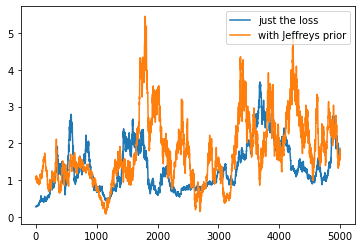

<Figure size 432x288 with 0 Axes>

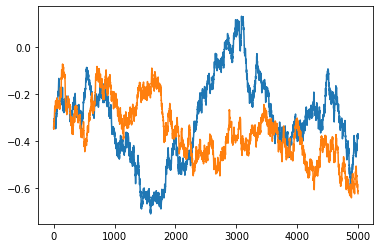

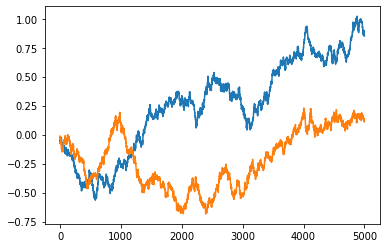

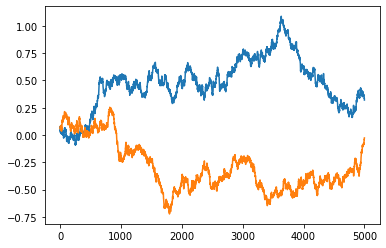

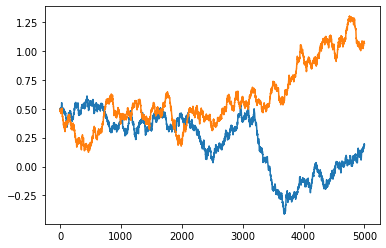

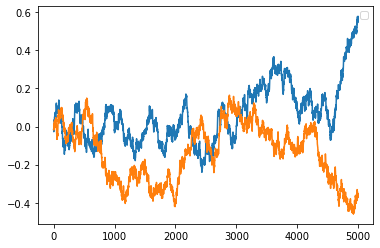

In [78]:
plt.plot(sampling_noJ[1], label='just the loss')
plt.plot(sampling_J[1], label='with Jeffreys prior')
plt.legend()

plt.figure()
for i in range(5):
    plt.figure()
    plt.plot(sampling_noJ[0][:, i], c='tab:blue')
    plt.plot(sampling_J[0][:, i], c='tab:orange')
plt.legend()


<Figure size 432x288 with 0 Axes>

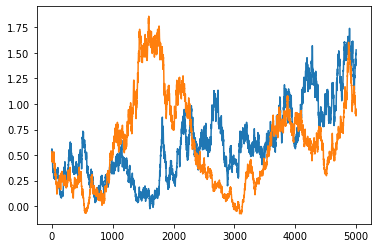

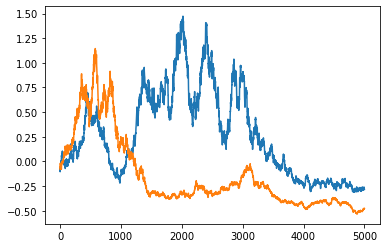

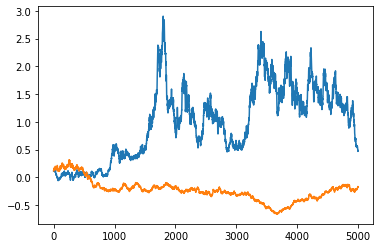

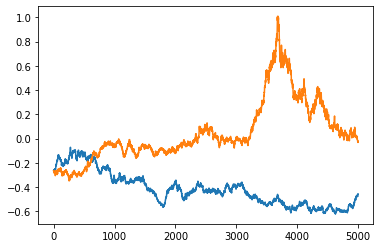

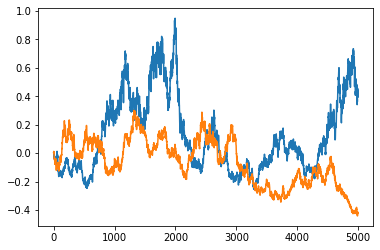

In [79]:
plt.figure()

for i in range(5):
    plt.figure()
    plt.plot(sampling_J[3][:, i])
    plt.plot(sampling_noJ[3][:, i])



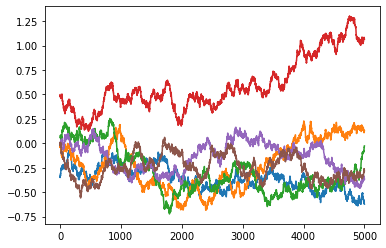

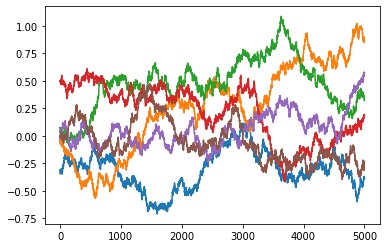

In [80]:
for i in range(6):

    plt.plot(sampling_J[0][:, i], '-', label='with Jeffreys prior')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

# plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(6):
    plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

# plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

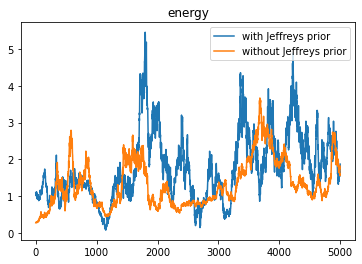

In [81]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.title('energy')
plt.legend()
# plt.text(2000, 0, s='av. acceptance: with J.' + str(sampling_J[2]) + '; without J.' + str(sampling_noJ[2]))

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


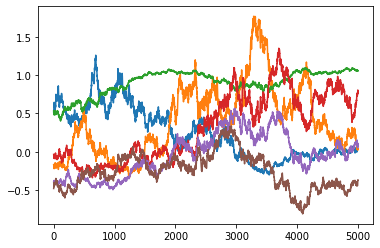

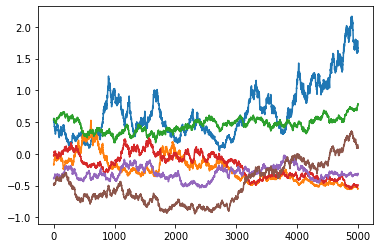

In [56]:
plt.plot(sampling_J[3])

plt.figure()
plt.plot(sampling_noJ[3])

#### try in lower dimensionality

In [98]:
vars(data.mol['AAAA'])

{'temperature': 1.0,
 'gexp': {'backbone1_gamma_3J': Array([[ 0.71697275,  0.73024844],
         [-0.06323511,  0.64952377]], dtype=float64)},
 'names': {'backbone1_gamma_3J': array([['0-1H5H4'],
         ['0-2H5H4'],
         ['1-1H5H4'],
         ['1-2H5H4'],
         ['2-1H5H4'],
         ['2-2H5H4'],
         ['3-1H5H4'],
         ['3-2H5H4']], dtype='<U7')},
 'ref': {'backbone1_gamma_3J': '='},
 'forward_model': <function MDRefine.MDRefine.data_loading.data_class.__init__.<locals>.my_forward_model(a, b, c=None)>,
 'forward_qs': {'backbone1_gamma': Array([[-0.7815259 ,  1.3352288 , -1.1212994 , ...,  1.185426  ,
          -0.83515507,  1.1691177 ],
         [-1.051306  ,  1.0546006 , -1.148108  , ...,  0.7603315 ,
          -1.0628304 ,  1.0667372 ],
         [-0.791389  ,  1.2605377 , -1.0543586 , ...,  1.1760662 ,
          -0.8869718 ,  1.367943  ],
         ...,
         [-1.0729688 ,  0.84991276, -1.1393695 , ...,  1.0201094 ,
          -0.99287504,  1.0446409 ],
         [-1.

In [13]:
s = 'backbone1_gamma_3J'

assert list(data.mol.keys()) == ['AAAA']
assert list(data.mol['AAAA'].g.keys()) == [s]

data.mol['AAAA'].gexp[s] = data.mol['AAAA'].gexp[s][:2, :]
data.mol['AAAA'].g[s] = data.mol['AAAA'].g[s][:, :2]
# data.mol['AAAA'].normg_mean[s] = data.mol['AAAA'].normg_mean[s][:2]
# data.mol['AAAA'].normg_std[s] = data.mol['AAAA'].normg_std[s][:2]
data.mol['AAAA'].n_experiments[s] = 2

In [14]:
out = minimizer(data, alpha=1)

vars(out)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

{'loss': Array(0.13515526, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': Array([-0.34266082, -0.03500603], dtype=float64)}},
 'minis': {'AAAA':   message: Optimization terminated successfully.
    success: True
     status: 0
        fun: -0.1351552580797724
          x: [-3.427e-01 -3.501e-02]
        nit: 4
        jac: [-3.021e-04  3.079e-04]
   hess_inv: [[ 3.846e-01  1.745e-02]
              [ 1.745e-02  8.193e-01]]
       nfev: 6
       njev: 6},
 'time': 0.5682539939880371,
 'D_KL_alpha': {'AAAA': Array(0.10368261, dtype=float64)},
 'abs_difference': {'AAAA': Array(1.97918644e-07, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([ 0.53454663, -0.07831135], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(0.06294569, dtype=float64)}},
 'logZ_new': {'AAAA': Array(0.07674421, dtype=float64)},
 'weights_new': {'AAAA': Array([1.09359221e-04, 7.84831950e-05, 1.08257070e-04, ...,
         7.84485810e-05, 8.12223382e-05, 1.16223015e-04], 

In [15]:
x_min = out.min_lambdas

x_min

{'AAAA': {'backbone1_gamma_3J': Array([-0.34266082, -0.03500603], dtype=float64)}}

In [16]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

In [17]:
x_min = flat_lambda(x_min)

x_min

array([-0.34266082, -0.03500603])

In [18]:
n = 30
delta = 1

x = np.linspace(x_min[0] - delta, x_min[0] + delta, n)
y = np.linspace(x_min[1] - delta, x_min[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [19]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)
        grid_vals_noJ[i, j] = out.loss_explicit

        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


In [20]:
out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)

vars(out).keys()

dict_keys(['loss', 'loss_explicit', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

/tmp/ipykernel_32735/2473262375.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
/tmp/ipykernel_32735/2473262375.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)


0.14143177510883598 13.415018188616912


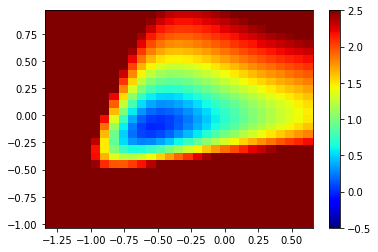

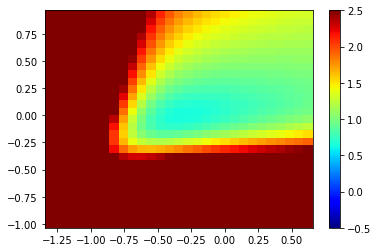

In [22]:
# matplotlib.rcParams['pcolor.shading']

# vmin = np.min(grid_vals_J)
# # vmax = np.max(grid_vals_J)
# vmax = vmin + 8

vmin = -0.5
vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


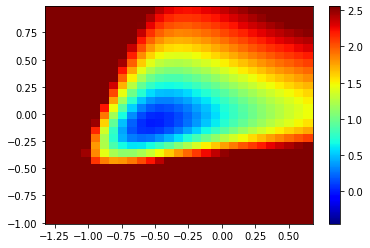

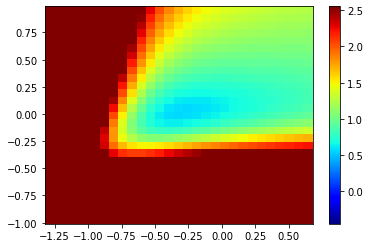

In [42]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
# vmax = np.max(grid_vals_J)
vmax = vmin + 3

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

In [24]:
x0 = x_min

In [25]:
# energy_function = {'fun': energy_fun, 'args': ([True])}

# proposal_full = {'fun': proposal, 'args': ([2])}

energy_function = lambda x : energy_fun(x, True)
proposal_move = lambda x : proposal(x, 2)

sampling_J = run_Metropolis(x0, proposal_move, energy_function, n_steps=500)

NameError: name 'energy_fun' is not defined

In [92]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


Text(0.5, 1.0, 'lambdas without Jeffreys prior')

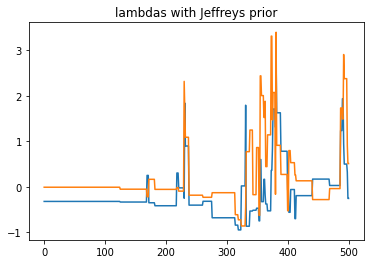

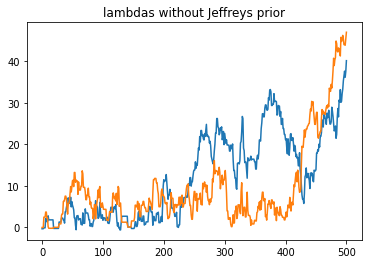

In [66]:
for i in range(2):

    plt.plot(sampling_J[0][:, i], '-')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.title('lambdas with Jeffreys prior')

# plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(2):
    plt.plot(sampling_noJ[0][:, i], '-')
    # plt.legend()

plt.title('lambdas without Jeffreys prior')

# plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

av. acceptance: with J.0.094; without J.0.74


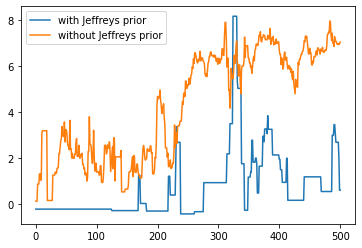

In [67]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.legend()

s = 'av. acceptance: with J.' + str(sampling_J[-1]) + '; without J.' + str(sampling_noJ[-1])
# plt.text(2000, 0, s=s)

print(s)

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


### 4. sampling force-field corrections

(sampling $P_\phi$ ensemble; only $\beta$ is finite, $\beta=1$)

In [35]:
result = minimizer(data, regularization={'force_field_reg': 'KL divergence'}, beta=1)

New evaluation:
loss:  11.612877669764105
gradient:  [-0.75592143] 

New evaluation:
loss:  11.659845830748091
gradient:  [0.33955028] 

New evaluation:
loss:  11.535323417245781
gradient:  [0.0435029] 

New evaluation:
loss:  11.534874187598614
gradient:  [0.01823386] 

New evaluation:
loss:  11.53478350116777
gradient:  [-0.00103383] 

New evaluation:
loss:  11.53478321763859
gradient:  [2.25814969e-05] 



In [36]:
pars = result.pars

pars

array([0.24187507])

In [37]:
print('av. values: ', data.mol['AAAA'].normg_mean)
print('\nexp. values: ', data.mol['AAAA'].gexp)

print('\nrefined av. values: ', result.av_g)

AttributeError: 'data_class' object has no attribute 'normg_mean'

In [38]:
deltap = 20

pars1 = np.arange(pars[0] - deltap, pars[0] + deltap, 0.3)

sum_dict = lambda my_dict : np.sum([x for x in my_dict.values()])

name_mol = data.properties.system_names[0]

ff_correction = data.mol[name_mol].ff_correction
fun_forces = jax.jacfwd(ff_correction, argnums=0)

loss = []
av_g = []
reg_ff = []
density = []
chi2 = []

for p1 in pars1:

    out = loss_function(np.array([p1]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
    
    loss.append(out.loss)
    av_g.append(unwrap_2dict(out.av_g)[0])
    reg_ff.append(out.reg_ff['AAAA'])

    chi2.append(sum_dict(out.chi2['AAAA']))

    # out.chi2['AAAA']
    density.append(local_density((fun_forces, np.array([p1]), data.mol[name_mol].f, data.mol[name_mol].g), out.weights_new[name_mol])[0])



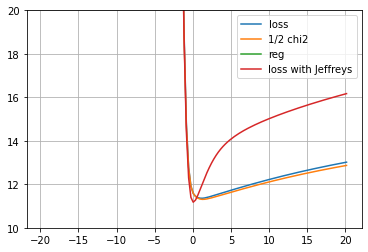

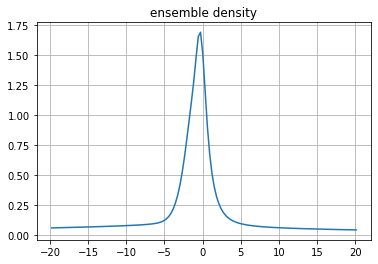

In [39]:
plt.plot(pars1, loss, label='loss')
plt.plot(pars1, 1/2*np.array(chi2), label='1/2 chi2')
plt.plot(pars1, reg_ff, label='reg')
plt.plot(pars1, loss - np.log(density), label='loss with Jeffreys')

# plt.yscale('log')
plt.ylim([10, 20])
plt.legend()
plt.grid()

plt.figure()
plt.plot(pars1, density)
plt.title('ensemble density')
plt.grid()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


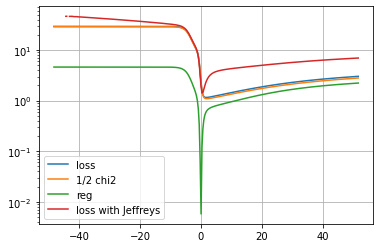

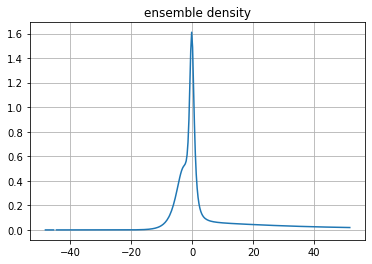

In [53]:
plt.plot(pars1, loss, label='loss')
plt.plot(pars1, 1/2*np.array(chi2), label='1/2 chi2')
plt.plot(pars1, reg_ff, label='reg')
plt.plot(pars1, loss - np.log(density), label='loss with Jeffreys')

plt.yscale('log')
plt.legend()
plt.grid()

plt.figure()
plt.plot(pars1, density)
plt.title('ensemble density')
plt.grid()

In [26]:
deltap = 10

pars1 = np.arange(pars[0] - deltap, pars[0] + deltap, 0.3)
pars2 = np.arange(pars[1] - deltap, pars[1] + deltap, 0.3)

loss = {}
av_g = {}
reg_ff = {}
density = {}

for p1 in pars1:
    print(p1)

    loss[p1] = {}
    av_g[p1] = {}
    reg_ff[p1] = {}
    density[p1] = {}

    for p2 in pars2:
        out = loss_function(np.array([p1, p2]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        
        loss[p1][p2] = out.loss
        av_g[p1][p2] = unwrap_2dict(out.av_g)[0]
        reg_ff[p1][p2] = out.reg_ff['AAAA']

        density[p1][p2] = local_density((fun_forces, np.array([p1, p2]), data.mol[name_mol].f, data.mol[name_mol].g), out.weights_new[name_mol])


-8.177663687307177
-7.8776636873071775
-7.577663687307178
-7.277663687307178
-6.977663687307178
-6.677663687307178
-6.377663687307178
-6.0776636873071785
-5.777663687307179
-5.477663687307179
-5.177663687307179
-4.877663687307179
-4.577663687307179
-4.27766368730718
-3.97766368730718
-3.67766368730718
-3.37766368730718
-3.0776636873071803
-2.7776636873071805
-2.4776636873071807
-2.177663687307181
-1.877663687307181
-1.5776636873071812
-1.2776636873071814
-0.9776636873071816
-0.6776636873071817
-0.3776636873071819
-0.07766368730718298
0.22233631269281773
0.5223363126928184
0.8223363126928174
1.1223363126928163
1.422336312692817
1.7223363126928177
2.0223363126928167
2.3223363126928156
2.6223363126928163
2.922336312692817
3.222336312692816
3.522336312692815
3.8223363126928156
4.122336312692816
4.422336312692815
4.722336312692814
5.022336312692815
5.322336312692816
5.6223363126928145
5.9223363126928135
6.222336312692814
6.522336312692815
6.822336312692814
7.122336312692813
7.42233631269281

In [27]:
flatten = lambda my_dict : np.array([[my_dict[l1][l2] for l1 in pars1] for l2 in pars2])

loss = flatten(loss)
density = np.array([[density[l1][l2][0] for l1 in pars1] for l2 in pars2])

av_g = flatten(av_g)

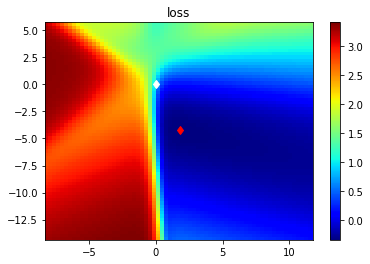

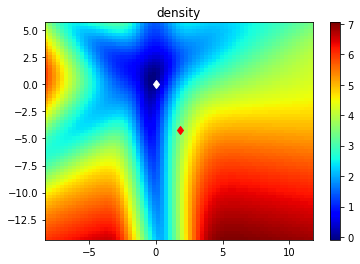

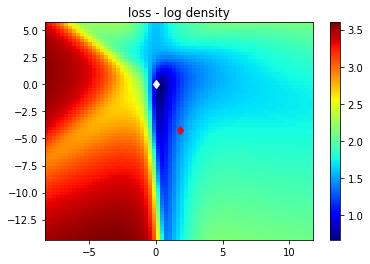

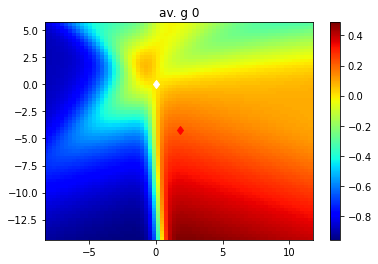

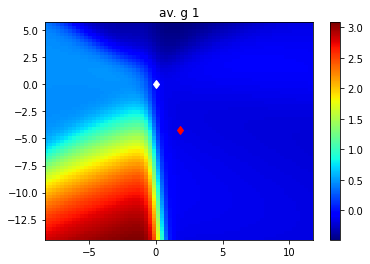

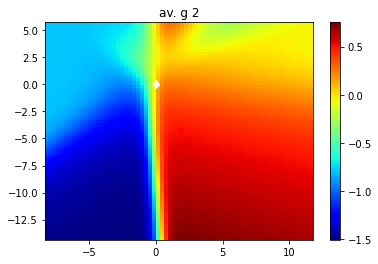

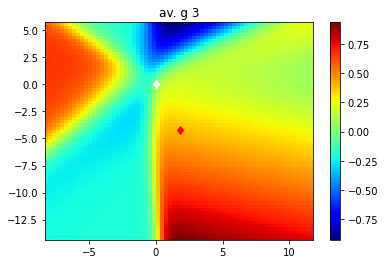

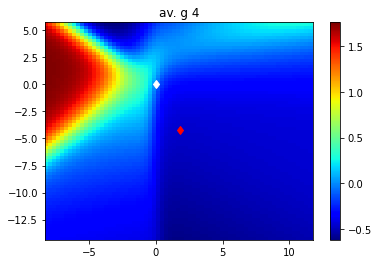

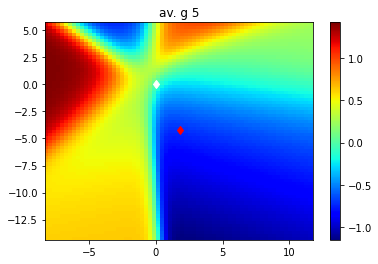

In [28]:
matplotlib.rcParams['pcolor.shading'] = 'auto'

plt.figure()
plt.title('loss')
plt.pcolormesh(pars1, pars2, np.log(loss), cmap='jet')  # , vmax=.0)
plt.colorbar()
plt.plot(pars[0], pars[1], 'dr')
plt.plot(0, 0, 'dw')

plt.figure()
plt.title('density')
plt.pcolormesh(pars1, pars2, -np.log(density), cmap='jet')
plt.colorbar()
plt.plot(pars[0], pars[1], 'dr')
plt.plot(0, 0, 'dw')

plt.figure()
plt.title('loss - log density')
plt.pcolormesh(pars1, pars2, np.log(loss - np.log(density)), cmap='jet')
plt.colorbar()
plt.plot(pars[0], pars[1], 'dr')
plt.plot(0, 0, 'dw')

for i in range(6):
    plt.figure()
    plt.title('av. g %i' % i)
    plt.pcolormesh(pars1, pars2, av_g[:, :, i], cmap='jet')
    plt.colorbar()
    plt.plot(pars[0], pars[1], 'dr')
    plt.plot(0, 0, 'dw')

In [29]:
x0 = pars

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([2.0])}

name_mol = data.properties.system_names[0]

ff_correction = data.mol[name_mol].ff_correction
fun_forces = jax.jacfwd(ff_correction, argnums=0)


def energy_fun(pars, which_measure):
    
    out = loss_function(pars, data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
    
    energy = out.loss  # which is loss_explicit if alpha is infinite

    av_g = unwrap_2dict(out.av_g)[0]

    if which_measure == 'jeffreys' or which_measure == 'dirichlet':
        my_tuple = (fun_forces, pars, data.mol[name_mol].f)
        measure, cov = local_density(my_tuple, out.weights_new[name_mol], which_measure=which_measure)
        energy -= np.log(measure)
    
    elif which_measure == 'average':
        my_tuple = (fun_forces, pars, data.mol[name_mol].f, data.mol[name_mol].g)
        measure, cov = local_density(my_tuple, out.weights_new[name_mol], which_measure=which_measure)
        energy -= np.log(measure)
    
    return energy, av_g

In [ ]:
fun_forces = jax.jacfwd(ff_correction, argnums=0)


In [30]:
energy_function = {'fun': energy_fun, 'args': ([None])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=1000)

energy_function = {'fun': energy_fun, 'args': (['jeffreys'])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=1000)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


acceptance:  0.483 0.866


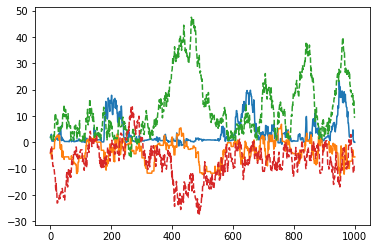

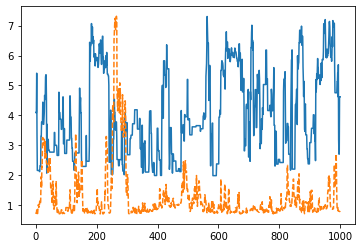

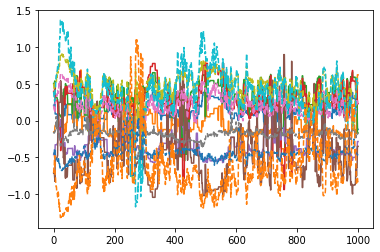

In [69]:
plt.plot(sampling_J[0], '-')
plt.plot(sampling_noJ[0], '--')

plt.figure()
plt.plot(sampling_J[1], '-')
plt.plot(sampling_noJ[1], '--')

print('acceptance: ', sampling_J[2], sampling_noJ[2])

plt.figure()
plt.plot(sampling_J[3], '-')
plt.plot(sampling_noJ[3], '--')

{'AAAA': {'backbone1_gamma_3J': DeviceArray([ 0.20664095, -0.15440301], dtype=float64), 'backbone2_beta_epsilon_3J': DeviceArray([0.50376395, 0.39505217], dtype=float64), 'sugar_3J': DeviceArray([-0.46122367, -0.71339527], dtype=float64)}}


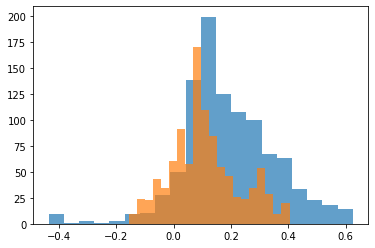

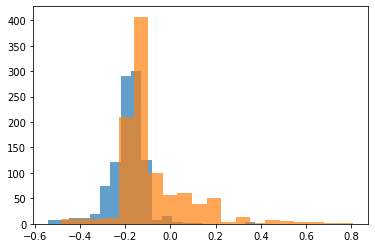

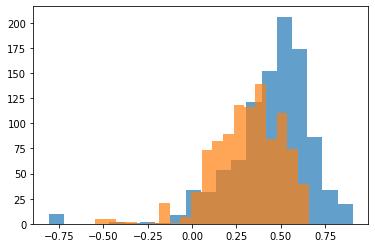

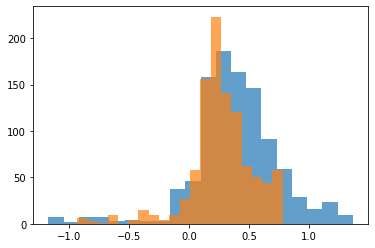

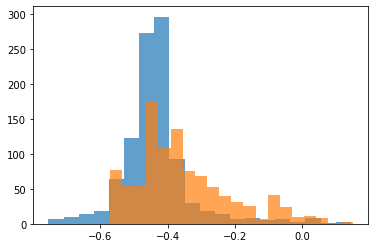

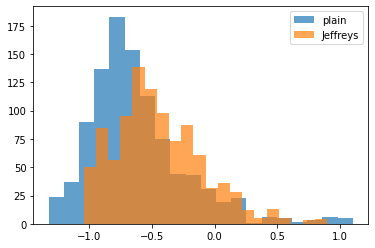

In [75]:
for i in range(sampling_J[3].shape[1]):
    plt.figure()
    plt.hist(sampling_noJ[3][:, i], bins=20, alpha=0.7, label='plain')
    plt.hist(sampling_J[3][:, i], bins=20, alpha=0.7, label='Jeffreys')

plt.legend()

print(result.av_g)

since we have just 2 coefficients, we can plot the posterior

In [71]:
n = 30
delta = 10

x = np.linspace(x0[0] - delta, x0[1] + delta, n)
y = np.linspace(x0[1] - delta, x0[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [82]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)
grid_vals_avg = np.zeros((sh[0], sh[1], 8))

name_mol = 'AAAA'

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.array([x[i], y[j]]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        grid_vals_noJ[i, j] = out.loss
        grid_vals_avg[i, j, :] = np.array(unwrap_2dict(out.av_g)[0])

        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


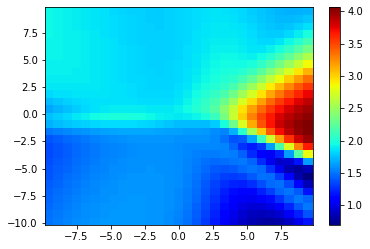

In [90]:
plt.pcolormesh(x, y, grid_vals_avg[:, :, 7], cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


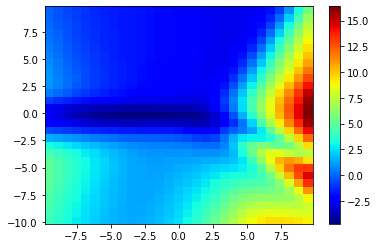

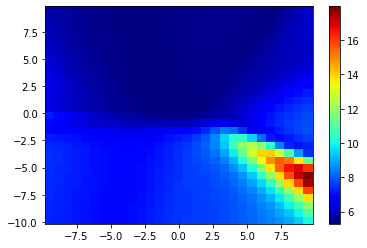

In [73]:
# plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


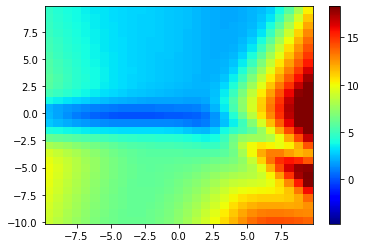

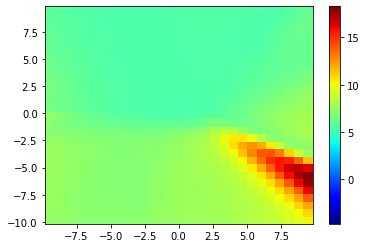

In [74]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
vmax = np.max(grid_vals_J)
# vmax = vmin + 8

# vmin = -0.5
# vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

# print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))